In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import GprModel
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import skgstat as skg
from skgstat import Variogram, OrdinaryKriging

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Experiment results for all 6 features (precip is removed)
# with fixed GPR model

In [4]:
plt.rcParams.update({'font.size': 16})

In [5]:
def subsample_data(data, sample_size = 10000):
    indices = np.random.choice(data.shape[0], sample_size, replace=False)
    
    return indices

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    target_scaler = StandardScaler()  
    scaled_train_y = target_scaler.fit_transform(train_y)
    scaled_test_y = target_scaler.transform(test_y)    
    
    return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

In [6]:
# # Modified from source: Dr.E Dr.Cui's private code 

# # Kernel function, RBF + constant
# # a is 2*sigma_f^2 as a single hyperparameter
# def rbf_kernel(x1, x2, length_scale, a, c=1):
#     """RBF kernel computation."""
#     dist_sq = cdist(x1, x2)**2
#     return a * np.exp(-dist_sq / (2 * length_scale**2)) + c

# # log-likelihood estimation
# def neg_log_likelihood(params, train_x, train_y, noise):
#     """Compute the negative log likelihood for Gaussian process."""
#     ls, a, c = params
#     K = rbf_kernel(train_x, train_x, ls, a, c=c) + noise**2 * np.eye(len(train_x))
#     try:
#         L = np.linalg.cholesky(K)
#         log_det = 2 * np.sum(np.log(np.diagonal(L)))
#         inv_y = np.linalg.solve(L.T, np.linalg.solve(L, train_y))
#         return 0.5 * np.dot(train_y.reshape(-1, train_y.shape[0])[0], inv_y.reshape(-1, train_y.shape[0])[0]) + 0.5 * log_det + 0.5 * len(train_x) * np.log(2 * np.pi)
#     except np.linalg.LinAlgError:
#         # In case the kernel matrix is not positive definite
#         return np.inf

# def gpr_model(train_x, train_y, test_x , test_y):
#     indices = subsample_data(train_x, sample_size = 2000)
    
#     sub_train_x = train_x[indices]
#     sub_train_y = train_y[indices]

#     gp_x, gp_x_test, gp_y, gp_y_test, feature_scaler, target_scaler = preprocess_data(sub_train_x, test_x, sub_train_y, test_y)

    
#     # A small number to ensure non-sparse matrix is invertible
#     alpha = 1e-10

#     # Initial hyperparameters
#     initial_ls = 1
#     initial_a = 1
#     initial_c = 1

#     # Optimization
#     result = minimize(neg_log_likelihood, 
#                       [initial_ls, initial_a, initial_c], 
#                       args=(gp_x, gp_y, 0.0), 
#                       method='L-BFGS-B', 
#                       bounds=[(1e-5, None), (1e-5, None), (1e-5, None)]
#                       )
#     # Optimized hyperparameters
#     optimized_ls, optimized_a, optimized_c = result.x

#     # Compute the RMSE for prediction
#     gp_preds = []
#     for row_index in range(0, gp_x_test.shape[0], 1000):
#         # specify a GP prior over the latent noise-free function
#         cov = rbf_kernel(gp_x_test[row_index:row_index+1000, :], gp_x_test[row_index:row_index+1000, :], optimized_ls, optimized_a, optimized_c)

#         #  let’s make predictions with these hypers (ls a)
#         K_x_xstar = rbf_kernel(gp_x, gp_x_test[row_index:row_index+1000, :], optimized_ls, optimized_a, optimized_c)
                
#         K_x_x = rbf_kernel(gp_x, gp_x, optimized_ls, optimized_a, optimized_c) + alpha*np.random.rand(gp_x.shape[0], gp_x.shape[0])
#         K_xstar_xstar = cov

#         post_mean = K_x_xstar.T @ np.linalg.inv((K_x_x)) @ gp_y
#         #post_cov = K_xstar_xstar - K_x_xstar.T @ np.linalg.inv((K_x_x)) @ K_x_xstar

#         # Calculate the upper and lower bound for 95% confidence interval, revert the normalization
#         #lw_bd =  target_scaler.inverse_transform(post_mean - (np.sqrt(np.diag(post_cov))*2).reshape(-1, 1))
#         #up_bd =  target_scaler.inverse_transform(post_mean + (np.sqrt(np.diag(post_cov))*2).reshape(-1, 1))
#         gp_preds.extend(target_scaler.inverse_transform(post_mean).reshape(-1,1).flatten())
        
#     rmse = mean_squared_error(target_scaler.inverse_transform(gp_y_test).reshape(-1,1).flatten(), gp_preds, squared=False)
    
#     print("Root Mean Squared Error:", rmse)
    
#     return rmse

In [16]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# %store training_results
# %store training_times
# %store test_results
# %store nn_histories
# %store gpr_test_results

#closing seesion, restarting kernel

# %store -r training_results
# %store -r training_times
# %store -r test_results
# %store -r nn_histories
# %store -r gpr_test_results

In [14]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]

# Expeirment related parameters
number_of_folds = 1 # have to be 10 fold

# Results containers for GP only, other models are saved
# GPR is a interpolation method, no need to record traning data.
gpr_test_results = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        # Select the wind speed only
        flatten_train_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
        
        # Reshape the data per time stamp
        flatten_train_x_reshaped = flatten_train_x.reshape(20,-1, flatten_train_x.shape[-1])
        flatten_train_y_reshaped = flatten_train_y.reshape(20,-1, flatten_train_y.shape[-1])
        
        flatten_test_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
         # Select the wind speed only
        flatten_test_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
              
        test_results_fold = []
        
        gpr_models = []
        for i in range(1, 2):            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")
            indices = np.random.choice(flatten_train_x_reshaped.shape[1], 400, replace=False)
            
            gpr_model = GprModel.GprModel()
            gpr_model.fit(np.vstack(flatten_train_x_reshaped[:,indices,:]), np.vstack(flatten_train_y_reshaped[:,indices,:].reshape(-1,1)))
            gpr_models.append(gpr_model)
            
            # GP models test
            gpr_preds = []
            for j in range(0, len(gpr_models)):
                #print(flatten_test_x_reshaped.shape)
                gpr_mdoel = gpr_models[j]
                mean, rmse = gpr_mdoel.predict(flatten_test_x, flatten_test_y)
                gpr_preds.append(rmse)
                
            test_results_fold.append({'gpr_test' : np.mean(gpr_preds)})
            
            print(test_results_fold)
            
            #After all folds are done, update the result containers
            gpr_test_results.append(test_results_fold)
        

In [15]:
do_experiment(number_of_neighbour_stations)

Currently running fold 1 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 124.28245462517742
[{'gpr_test': 124.28245462517742}]
Currently running fold 1 for 2 stations
[3.30379245e+00 9.90312901e-01 1.00000000e-05]
Root Mean Squared Error: 8.098453253845573
[{'gpr_test': 8.098453253845573}]
Currently running fold 1 for 3 stations
[7.51688040e+00 9.82515357e-01 5.70249420e-03]
Root Mean Squared Error: 7.383525517000387
[{'gpr_test': 7.383525517000387}]
Currently running fold 1 for 4 stations
[1.03419793e+01 9.97532285e-01 9.98582939e-03]
Root Mean Squared Error: 7.266723098591452
[{'gpr_test': 7.266723098591452}]
Currently running fold 1 for 5 stations
[1.23018144e+01 9.77525949e-01 1.00000000e-05]
Root Mean Squared Error: 7.269252212307546
[{'gpr_test': 7.269252212307546}]
Currently running fold 1 for 6 stations
[1.48410021e+01 1.00347042e+00 9.66433255e-03]
Root Mean Squared Error: 7.246991937014375
[{'gpr_test': 7.246991937014375}]
Currently running fold 1 for 7 stations
[1.72198105e+01 1.01231096e+00 1.35924486e-02]
Roo

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[16.94454272  0.45934593  0.72651965]
Root Mean Squared Error: 7.125519317911804
[{'gpr_test': 7.125519317911804}]
Currently running fold 1 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[20.53340621  0.62211987  0.71544141]
Root Mean Squared Error: 7.096831995981307
[{'gpr_test': 7.096831995981307}]
Currently running fold 1 for 10 stations
[2.49601919e+01 1.05737242e+00 1.86770649e-02]
Root Mean Squared Error: 7.09245097390881
[{'gpr_test': 7.09245097390881}]
Currently running fold 1 for 11 stations
[2.77053880e+01 1.09756037e+00 1.83188288e-02]
Root Mean Squared Error: 7.123352723065476
[{'gpr_test': 7.123352723065476}]
Currently running fold 1 for 12 stations
[2.85559107e+01 1.12267643e+00 1.72043745e-02]
Root Mean Squared Error: 7.136209476848252
[{'gpr_test': 7.136209476848252}]


In [26]:
# gpr_test_results=[]
# gpr_test_results.append({'gpr_test': 124.28245462517742})
# gpr_test_results.append({'gpr_test': 8.098453253845573})
# gpr_test_results.append({'gpr_test': 7.383525517000387})
# gpr_test_results.append({'gpr_test': 7.266723098591452})
# gpr_test_results.append({'gpr_test': 7.269252212307546})
# gpr_test_results.append({'gpr_test': 7.246991937014375})
# gpr_test_results.append({'gpr_test': 7.127975366729728})
# gpr_test_results.append({'gpr_test': 7.125519317911804})
# gpr_test_results.append({'gpr_test': 7.096831995981307})
# gpr_test_results.append({'gpr_test': 7.09245097390881})
# gpr_test_results.append({'gpr_test': 7.123352723065476})
# gpr_test_results.append({'gpr_test': 7.136209476848252})

exp
7.2311±0.0
6.7706±0.015
6.2463±0.0068
exp
7.0071±0.0
6.7166±0.0
5.8777±0.0068
exp
6.9039±0.0
6.1219±0.0262
5.6055±0.0053
exp
6.6041±0.0
6.6041±0.0
5.5082±0.0067
exp
6.4277±0.0
6.4277±0.0
5.4781±0.0045
exp
6.4203±0.0
6.4203±0.0
5.4465±0.0047
exp
6.456±0.0
6.456±0.0
5.4597±0.0055
exp
6.5277±0.0
6.5277±0.0
5.446±0.0046
exp
6.452±0.0
6.452±0.0
5.4436±0.0054
exp
6.4835±0.0
6.4834±0.0
5.6134±0.4956
exp
6.5401±0.0
6.54±0.0
5.454±0.0081
exp
6.5716±0.0001
6.5715±0.0
5.4622±0.0114


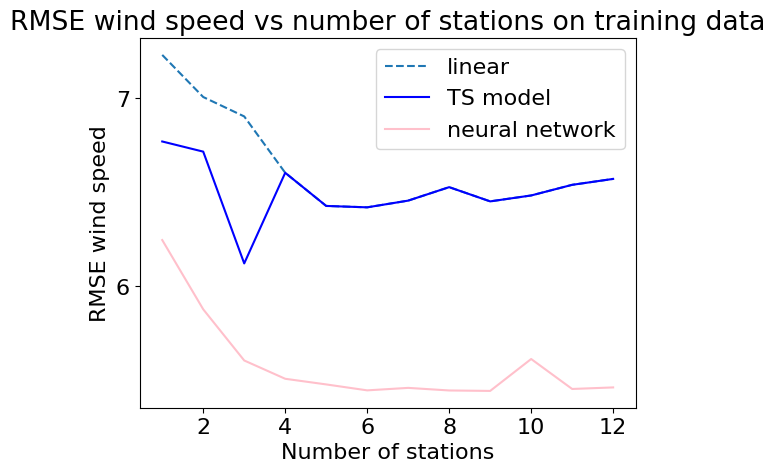

In [22]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7202)
# fcm_train_plot.insert(1, 6.6459)
# nn_train_plot.insert(1, 5.8963)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


exp
7.2407±0.0
6.7804±0.0128
6.235±0.0081
exp
7.0117±0.0
6.7255±0.0
5.8649±0.0073
exp
6.916±0.0
6.1403±0.0276
5.5969±0.0055
exp
6.6074±0.0
6.6074±0.0
5.5032±0.0077
exp
6.4329±0.0
6.4329±0.0
5.4698±0.0053
exp
6.4353±0.0
6.4353±0.0
5.4486±0.0058
exp
6.4589±0.0
6.4589±0.0
5.4641±0.0054
exp
6.5369±0.0
6.5368±0.0
5.4522±0.0037
exp
6.4553±0.0
6.4552±0.0
5.4465±0.0048
exp
6.4915±0.0
6.4915±0.0
5.6232±0.5039
exp
6.5555±0.0001
6.5554±0.0
5.4636±0.0075
exp
6.5839±0.0001
6.5838±0.0
5.4686±0.0078


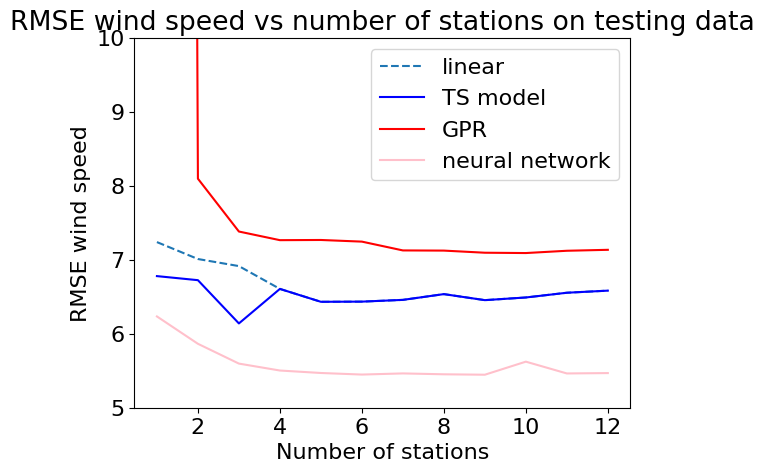

In [28]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in test_results:
    li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
    fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
    nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(exp['gpr_test'])

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, gpr_test_plot, label='GPR', c='red')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper right")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')

for exp in test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


In [29]:
opt_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/6x.csv', index_col=0)
opt_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/6y.csv', index_col=0)

FCM traning RMSE: 5.990530384069622
FCM traning RMSE: 5.998535157697825
FCM traning RMSE: 5.8685894659698965
FCM traning RMSE: 5.8662477183733985
FCM traning RMSE: 5.837188704154438
FCM traning RMSE: 5.845354653823507
FCM traning RMSE: 5.823567994527309
FCM traning RMSE: 5.688513387155957
FCM traning RMSE: 5.691673261457757
FCM traning RMSE: 5.773722861135566


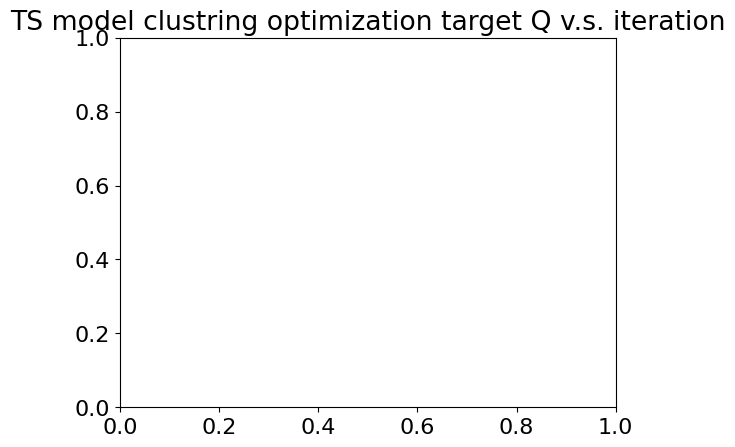

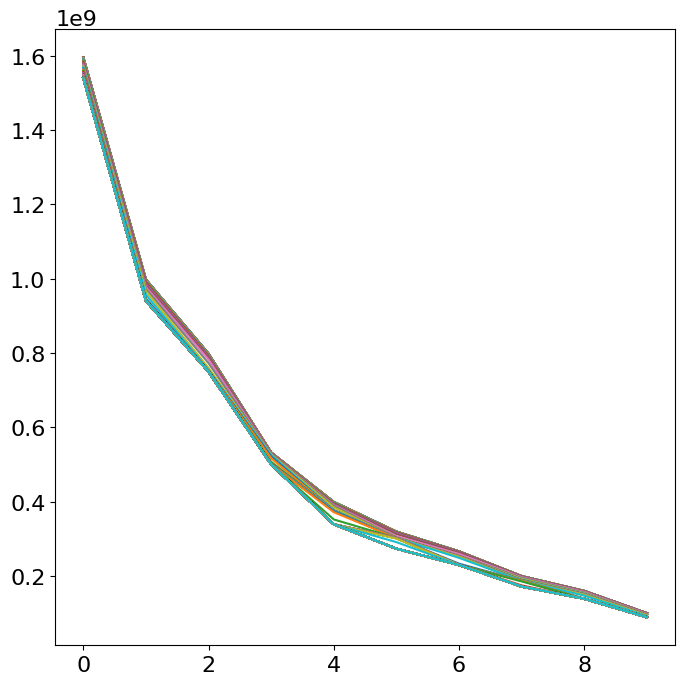

In [30]:
# Plot Q vs # of Nc
# Fcm hyperparameters
FCM_Ncs = [5,8,10,15,20,25,30,40,50,80]
FCM_m = 2
#tol = 1e-5
max_iter = 200
qs = []

for FCM_Nc in FCM_Ncs:   
    N = opt_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    temp_qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, opt_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(opt_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        temp_qs.append(q)

        # 检查是否收敛
#         if np.linalg.norm(U - U_old) < tol:
#             break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), opt_x))
    H = np.zeros((N, FCM_Nc * (opt_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (opt_x.shape[1] + 1, 1)).T
        H[:, (j * (opt_x.shape[1] + 1)):((j + 1) * (opt_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(opt_y)

        
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(opt_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(opt_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    qs.append(temp_qs)
    
plt.title('TS model clustring optimization target Q v.s. iteration')
plt.figure(figsize=(8,8))
plt.plot(qs)

In [42]:
np.array(qs).shape

(10, 200)

Text(0.5, 1.0, 'TS model optimization target Q v.s. iteration for differenct number of rules')

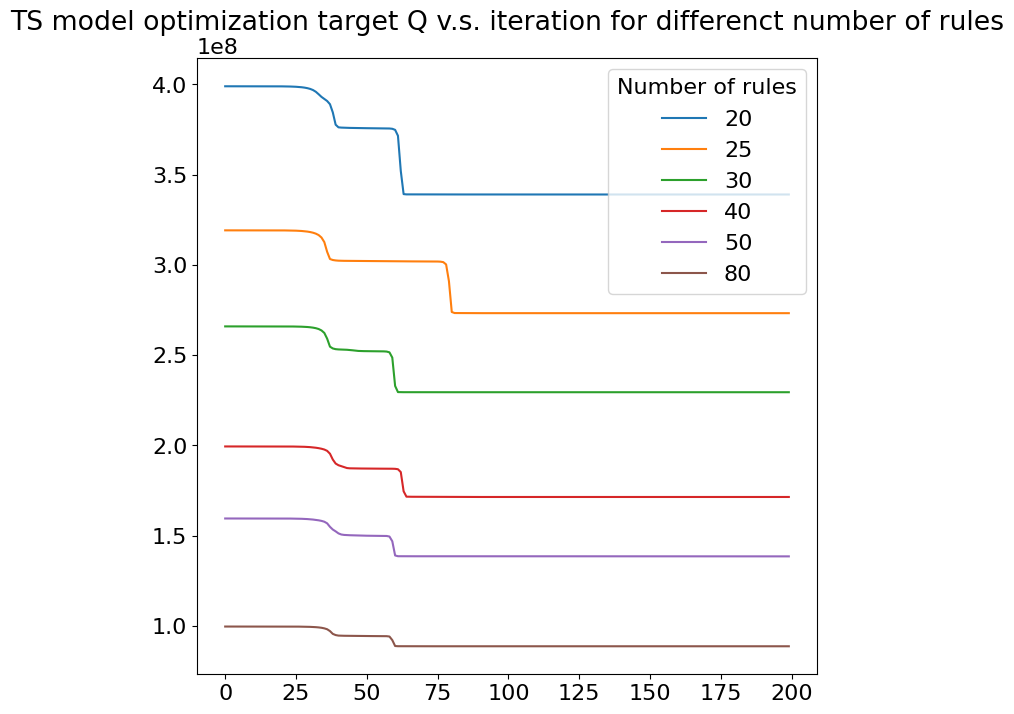

In [51]:
plt.figure(figsize=(8,8))

for exp in qs[4:]:
    plt.plot(exp)

plt.legend(FCM_Ncs[4:], title="Number of rules")
plt.title('TS model optimization target Q v.s. iteration for differenct number of rules')